In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as srn
import sys  
import os

In [2]:
cwd = os.getcwd() 
sys.path.append(cwd+"/data_load/")
sys.path.append(cwd+"/models/")
sys.path.append(cwd+"/metrics/")

### CIFAR-10 

#### 1. Prepare dataset

In [3]:
dataset = "CIFAR-10"

In [4]:
train_path = cwd+"/data/cifar-10_data/normal/"
test_path = cwd+"/data/cifar-10_data/anoma/"

In [5]:
from load_datasets import prepare_cifar_data_for_rpca_forest_ocsvm,prepare_cifar_data_for_cae_ocsvm

Using TensorFlow backend.


In [6]:
[raw_train,  raw_test] =  prepare_cifar_data_for_rpca_forest_ocsvm(train_path,test_path)
print (raw_train.shape)
print (raw_test.shape)

[INFO] loading images for training...
[INFO] preparing test data (anomalous )...
(50, 3072)
(5, 3072)


#### 2. Prepare models for transfer learning

In [7]:
modelpath = cwd + "/models/transfer_learning/cae_autoencoders/trained_models/cifar10_conv_3_id_32_e_1000_encoder.model"
ae2_modelpath = cwd + "/models/transfer_learning/cae_autoencoders/trained_models/cifar10_AE2_3_id_256_e_10_encoder.model"

In [8]:
[data_train, data_test] =  prepare_cifar_data_for_cae_ocsvm(train_path,test_path, modelpath) 

[INFO] loading network...
base_model.output (?, 32)
base_model.input (?, 32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
__________________________________________________________

/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### 3. OC-NN

3 on-nn models with different activation are avaliable and can be called via these function call:

1. tf_OneClass_NN_linear(data_train, data_test, nu, verbose=True)
2. tf_OneClass_NN_sigmoid(data_train, data_test, nu, verbose=True)
3. tf_OneClass_NN_relu(data_train, data_test, nu, verbose=True)

Each returns a list of the following format:
[pos_decisionScore, neg_decisionScore, trainTime, testTime]

(source at ./models/transfer_learning/tf_Cifar_OC_NN_Models.py)

**Take oc_nn_linear as example**

In [9]:
from tf_Cifar_OC_NN_Models import tf_OneClass_NN_linear,tf_OneClass_NN_sigmoid,tf_OneClass_NN_relu

nu = 0.1 #initial quantile (?)

ocnn_linear_result = tf_OneClass_NN_linear(data_train,data_test,nu, verbose=False)

Input Shape: 32
====== Session Completed ======
Writing file to  /Users/litangqing/tensor-conda/cleaned_ocNN/Decision_Scores/oc_nn_linear_cifar.csv


***Access results***

In [10]:
pos_decision_score_linear = ocnn_linear_result[0]
neg_decision_score_linear = ocnn_linear_result[1]
pos_decision_score_linear[:10]

array([12.424004  , -0.07378769, 10.797293  ,  5.941002  ,  1.5489948 ,
        6.645074  ,  2.126851  ,  1.7263534 , 14.279143  ,  2.7593517 ],
      dtype=float32)

In [11]:
train_time, test_time = ocnn_linear_result[2], ocnn_linear_result[3]
(train_time, test_time)

(1.05110502243042, 0.002557992935180664)

In [12]:
decision_score_linear = pd.read_csv("./Decision_Scores/oc_nn_linear_cifar.csv")
decision_score_linear.head()

,Normal,Anomaly
0,12.424004,-8.908887
1,-0.073788,-14.335208
2,10.797293,-8.288349
3,5.941002,-20.861267
4,1.548995,-1.898455


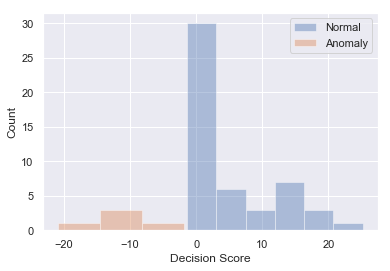

In [13]:
srn.set()
srn.distplot(decision_score_linear['Normal'],kde=False,label="Normal")
srn.distplot(decision_score_linear['Anomaly'][~pd.isnull(decision_score_linear['Anomaly'])],
             kde=False,label='Anomaly')
plt.xlabel("Decision Score")
plt.ylabel("Count")
plt.legend()